#### July 21, 2022
### HMDA analysis via:
#### Source: 2021 National Loan Level Dataset from the Consumer Financial Protection Bureau of the  Federal Financial Institution Examination Council, per the Home Mortgage Disclosure Act of 1975
https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2021)



helpful source from medium: https://imitra14.medium.com/racial-discrimination-in-the-mortgage-market-insights-from-data-ba24d5f0bacf

background info from NCRC: 
(1) https://www.ncrc.org/initial-analysis-of-2021-hmda-data-the-year-that-homes-became-atms-again/
(2) https://ncrc.org/2020-hmda-preliminary-analysis/



#### deep dive report: https://files.consumerfinance.gov/f/documents/cfpb_new-revised-data-points-in-hmda_report.pdf
#### understanding a covered loan, and the scope of transaction data: https://files.consumerfinance.gov/f/documents/cfpb_2022-hmda-transactional-coverage.pdf
#### brief from Urban https://www.urban.org/urban-wire/what-different-denial-rates-can-tell-us-about-racial-disparities-mortgage-market

*Very interesting ML project on approvals/denials by race and other characteristics: https://q-shick.github.io/portfolio/proj_hmda.html

In [1]:
import numpy as np
import pandas as pd
import re
import random
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)
import os
os. getcwd()
os.chdir('/Users/trevor.mattos/Desktop/nycdsa/Python/hmda-loan-records-analysis')


#### Read in a 1 percent sample of the 26 million HMDA records
code from: https://www.kaggle.com/questions-and-answers/53925

In [72]:
# read in 1 percent sample
df=pd.read_csv("2021_public_lar.csv", 
               header=None,
                    skiprows = lambda i: random.random() >0.05)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [74]:
# read in a separate dataframe to get the headers
df_cols = pd.read_csv("2021_public_lar.csv", header=None, nrows = 1)
# concatenate the new headers and the data
df1=pd.concat([df_cols, df], axis = 0)
# set first row as column headers and name df2
df2=df1.rename(columns=df1.iloc[0]).drop(df1.index[0])

### Data cleaning:

In [75]:
# things to drop

#remove free form race entries (drop these rows)
df2 = df2[df2.derived_race != 'Free Form Text Only']

#remove free form ethnicity entries (drop these rows)
df2 = df2[df2.derived_ethnicity != 'Free Form Text Only']

# drop actions that are not relevant to approval or denial
df2 = df2[df2.action_taken != 4]
df2 = df2[df2.action_taken != 5]
df2 = df2[df2.action_taken != 6]

# loan purpose not applicable
df2 = df2[df2.loan_purpose != 5]

# debt to income ratio exempt
df2 = df2[df2.debt_to_income_ratio != 'Exempt']


In [76]:
# remove 'exempt' from property_value (assign np.nan)
df2.loc[df2['property_value']=='Exempt', 'property_value']=np.nan

# recast loan amount as numeric
df2['loan_amount']=pd.to_numeric(df2.loan_amount)

#recast property_value as numeric
df2['property_value']=pd.to_numeric(df2.property_value)

#recast income to numeric and change metric to dollars (instead of thousands of dollars)
df2['income']=pd.to_numeric(df2.income)
df2['income']=df2['income']*1000 # put in thousands

# recast interest rate and set exempt values to NA
df2.loc[df2['interest_rate']=='Exempt', 'interest_rate']=np.nan
df2['interest_rate']=pd.to_numeric(df2['interest_rate'])

# recast total loan costs and set exempt values to NA
df2.loc[df2['total_loan_costs']=='Exempt', 'total_loan_costs']=np.nan
df2['total_loan_costs']=pd.to_numeric(df2['total_loan_costs'])

# recast loan to value ratio as numeric
df2.loc[df2['combined_loan_to_value_ratio']=='Exempt', 'combined_loan_to_value_ratio']=np.nan
df2['combined_loan_to_value_ratio']= pd.to_numeric(df2['combined_loan_to_value_ratio'])

# dummy var for single family home
df2['singlefam']=np.where(df2['derived_dwelling_category']==('Single Family (1-4 Units):Site-Built' or 'Single Family (1-4 Units):Manufactured'),1,0)

# recode occupancy type with meaninful string values
df2['occupancy_type'] = df2['occupancy_type'].replace(
    [1,2,3],['primary residence','second residence','investment property'])

# recode loan purpose with meaninful string values
df2['loan_purpose'] = df2['loan_purpose'].replace(
    [1,2,31,32,4,5],['Home purchase','Home improvement','Refinancing', 'Cash-out refinancing',
                    'Other purpose', 'Not applicable'])




In [77]:
# recode loan amounts into buckets

def incbucket(amt):
    if amt<50000:
        return '\$0-\$49,999'
    elif (amt>=50000) and (amt <100000):
        return '\$50,000-\$99,999'
    elif (amt>=100000) and (amt<150000):
        return '\$100,000-\$149,999'
    elif (amt>=150000) and (amt<200000):
        return '\$150,000-\$199,999'
    elif (amt>=200000) and (amt<250000):
        return '\$200,000-\$249,999'
    elif (amt>=250000):
        return '\$250,000+'

df2['incgroups']=df2['income'].apply(incbucket)

In [78]:
# recode loan amounts into buckets

def lnbucket(amt):
    if amt<150000:
        return '\$0-\$149,999'
    elif (amt>=150000) and (amt <300000):
        return '\$150,000-\$299,999'
    elif (amt>=300000) and (amt<450000):
        return '\$300,000-\$449,999'
    elif (amt>=450000):
        return '\$450,000+'

df2['loanbuckets']=df2['loan_amount'].apply(lnbucket)


In [79]:
# recode action taken into approval and denial categories (binary)
def approval(action):
    if action==1 or action==2 or action==8:
        return 1
    elif action==3 or action==7:
        return 0


df2['outcome']=df2['action_taken'].apply(approval)


In [836]:
# cross tabulate race and ethnicity to help in recoding
#pd.crosstab(df2.derived_race, df2.derived_ethnicity, dropna=False)

In [80]:
# create function to recode race and ethnicity into one merged variable
def racegroups(df):
    if (df['derived_race']=='White') and (df['derived_ethnicity'] =='Not Hispanic or Latino'):
        return 'White'
    elif ((df['derived_race']=='Race Not Available') and ((df['derived_ethnicity'] == 'Not Hispanic or Latino') or (df['derived_ethnicity'] == 'Ethnicity Not Available' ))) or (df['derived_ethnicity'] == 'Ethnicity Not Available'):
        return 'Race or Ethnicity Not Available'
    elif (df['derived_race']=='Black or African American') and (df['derived_ethnicity'] == 'Not Hispanic or Latino'):
        return 'Black or African American'
    elif ((df['derived_race']=='Asian') or (df['derived_race']=='Native Hawaiian or Other Pacific Islander'))  and (df['derived_ethnicity'] == 'Not Hispanic or Latino'):
        return 'AAPI' 
    elif ((df['derived_race']=='Joint') or (df['derived_race']=='2 or more minority races')) and (df['derived_ethnicity'] == 'Not Hispanic or Latino'):
        return 'Multiracial'
    elif (df['derived_race']=='American Indian or Alaska Native') and (df['derived_ethnicity'] == 'Not Hispanic or Latino'):
        return 'Native American'
    elif (df['derived_ethnicity'] == 'Hispanic or Latino') or (df['derived_ethnicity'] == 'Joint') :
        return 'Hispanic or Latino'
    #elif (df['derived_ethnicity'] == 'Ethnicity Not Available'):
        #return 'Ethnicity Not Available'
    
#use racegroups function to create newrace variable
df2['newrace'] = df2.apply(racegroups, axis=1)

In [329]:
# drop naN in loan_amount
#df2['property_value'] = df2[df2['property_value'].notna()]
#df2['property_value']=df2.property_value.astype(int)
#df2.property_value
#df2.loan_amount

In [81]:
#recode debt_to_income_ratio so that groupings are somewhat comparable
# bucket all 30-39%
df2['debt_to_income_ratio'].replace('^3.*','30%-39%', regex=True, inplace=True)
# bucket all 40-49%
df2['debt_to_income_ratio'].replace('^4.*','40%-49%', regex=True, inplace=True)
df2['debt_to_income_ratio'].value_counts()

30%-39%     251131
40%-49%     246221
20%-<30%    179850
<20%         84001
50%-60%      43421
>60%         32321
Name: debt_to_income_ratio, dtype: int64

### Data exploration and visualization:

In [842]:
#df2.groupby('newrace').agg({'income': 'median', 'denied': 'mean'})

Text(0.5, 1.0, 'loan_amount')

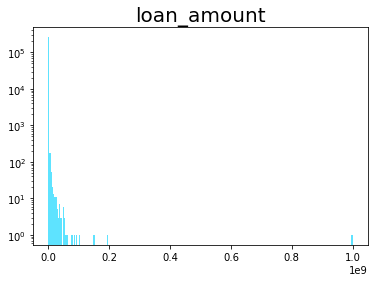

In [104]:
plt.hist(df3['loan_amount'], log=True, bins=250, color="#5ee3ff")
plt.title('loan_amount', fontsize = 20)

In [94]:
#plt.hist(np.log(df2['income']), bins=200, color="#5ee3ff")
#plt.hist(df2['income'], bins=200, color="#5ee3ff")
#plt.title('income distribution', fontsize = 20)
#plt.xlim( [ 0, 10000000 ] )


#plt.hist(np.log(df['budget'].dropna()), bins = 100, color = "#5ee3ff")


### EDA:

#### characteristics of loan requested:
 loan purpose  
 loan amount (create buckets)  
 loan applications by occupancy type  

#### characteristics of applicant:
 loan applications by race/ethnicity, and sex (maybe cross tabulate, age  
 income, buckets  
 debt to income ratio  

 
 #### outcomes:
 
 ##### decision:
 
  loan applications by action taken  
  denial reason 1 
 
 ##### cost of debt:
 
  interest rate  
  loan to value ratio  
  total loan costs  
  
#### identifying loan and applicant characteristics most correlated with key outcomes:

  loan purpose by approved/denied  
  

  





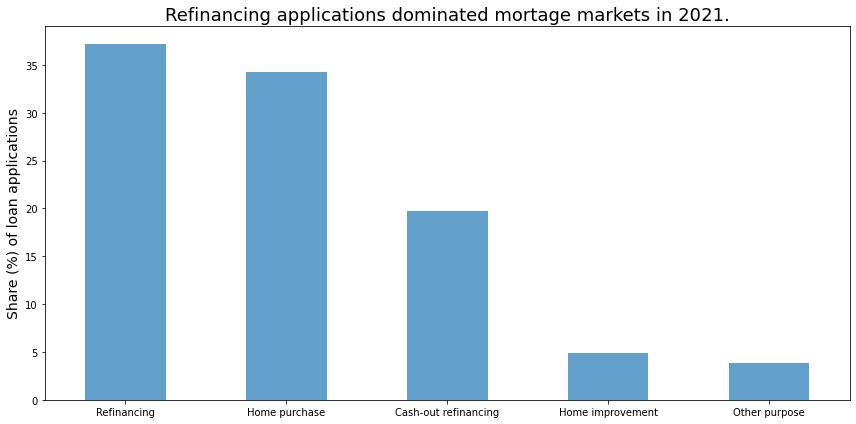

In [82]:
# graph 1a

plt.figure(figsize = (12,6))

purpdf=df2.groupby('loan_purpose')[['loan_purpose']].agg('count')/(df2.loan_purpose.count())*100
purpdf=purpdf.rename(columns={'loan_purpose':'lnpurp'})

purpdf['lnpurp'].sort_values(ascending=False).plot.bar(alpha=.7)
plt.xlabel('', fontsize=14)
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylabel('Share (%) of loan applications', fontsize=14)
plt.title('Refinancing applications dominated mortage markets in 2021.', fontsize=18)

plt.tight_layout()
plt.savefig("graph1a.jpg", dpi=250)





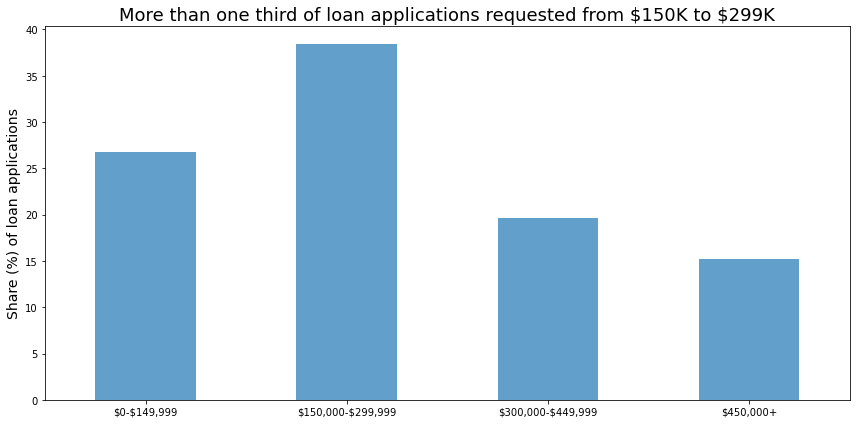

In [83]:
# graph 1B

plt.figure(figsize = (12,6))

loandf=df2.groupby('loanbuckets')[['loanbuckets']].agg('count')/(df2.newrace.count())*100
loandf=loandf.rename(columns={'loanbuckets':'lnbkt'})

loandf['lnbkt'].plot.bar(alpha=.7)
plt.xlabel('', fontsize=14)
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylabel('Share (%) of loan applications', fontsize=14)
plt.title('More than one third of loan applications requested from \$150K to \$299K', fontsize=18)

plt.tight_layout()
plt.savefig("graph1b.jpg", dpi=250)



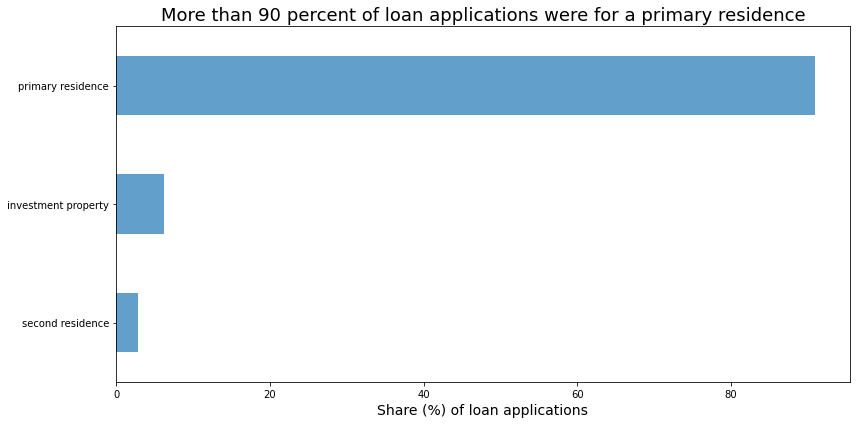

In [84]:

#graph 1C
plt.figure(figsize = (12,6))

occdf=df2.groupby('occupancy_type')[['occupancy_type']].agg('count')/(df2.newrace.count())*100
occdf=occdf.rename(columns={'occupancy_type':'occtype'})

occdf['occtype'].sort_values(ascending=True).plot.barh(alpha=.7)
plt.xlabel('Share (%) of loan applications', fontsize=14)
plt.ylabel('')
plt.title('More than 90 percent of loan applications were for a primary residence', fontsize=18)

plt.tight_layout()
plt.savefig("graph1c.jpg", dpi=250)



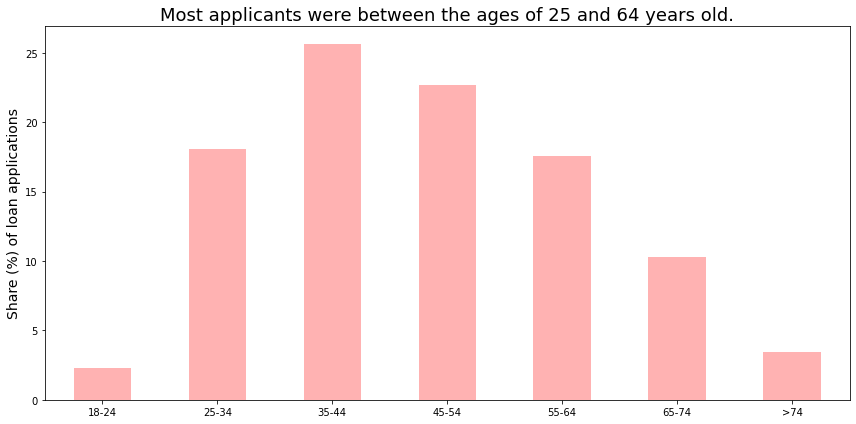

In [85]:
#2a

df2['applicant_age']=df2['applicant_age'].replace(['<25'],['18-24'])

agedf=df2[df2.applicant_age != '8888']
agedf=agedf.groupby('applicant_age')[['applicant_age']].agg('count')/(agedf.applicant_age.count())*100
agedf=agedf.rename(columns={'applicant_age':'agegroup'})


plt.figure(figsize = (12,6))
agedf['agegroup'].plot.bar(color='red', alpha=0.3)
plt.xlabel('', fontsize=14)
plt.ylabel('Share (%) of loan applications', fontsize=14)
plt.xticks(rotation=0, horizontalalignment="center")

plt.title('Most applicants were between the ages of 25 and 64 years old.', fontsize=18)

plt.tight_layout()
plt.savefig("graph2a.jpg", dpi=250)



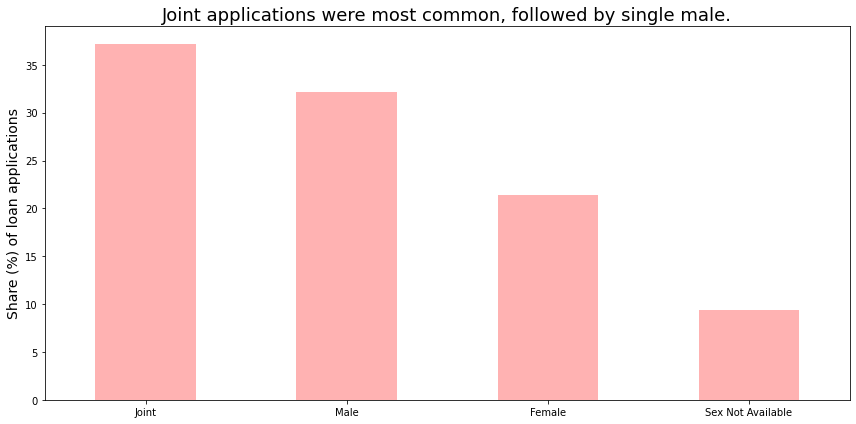

In [104]:
#2b
sexdf=df2.groupby('derived_sex')[['derived_sex']].agg('count')/(df2.derived_sex.count())*100
sexdf=sexdf.rename(columns={'derived_sex':'sex'})


plt.figure(figsize = (12,6))
sexdf['sex'].sort_values(ascending=False).plot.bar(color='red', alpha=0.3)
plt.xlabel('', fontsize=14)
plt.ylabel('Share (%) of loan applications', fontsize=14)
plt.xticks(rotation=0, horizontalalignment="center")

plt.title('Joint applications were most common, followed by single male.', fontsize=18)

plt.tight_layout()
plt.savefig("graph2b.jpg", dpi=250)





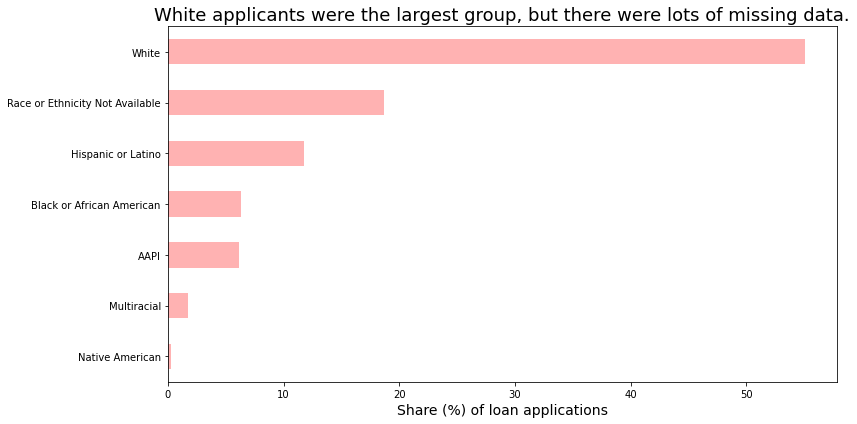

In [90]:
#2c

# calculate share of applicants by race and plot in next cell
racedf=df2.groupby('newrace')[['newrace']].agg('count')/(df2.newrace.count())*100
racedf=racedf.rename(columns={'newrace':'raceshare'})


plt.figure(figsize = (12,6))
racedf['raceshare'].sort_values(ascending=True).plot.barh(color='red', alpha=0.3)
plt.xlabel('Share (%) of loan applications', fontsize=14)
plt.ylabel('', fontsize=14)
plt.title('White applicants were the largest group, but there were lots of missing data.', fontsize=18)

plt.tight_layout()
plt.savefig("graph2c.jpg", dpi=250)


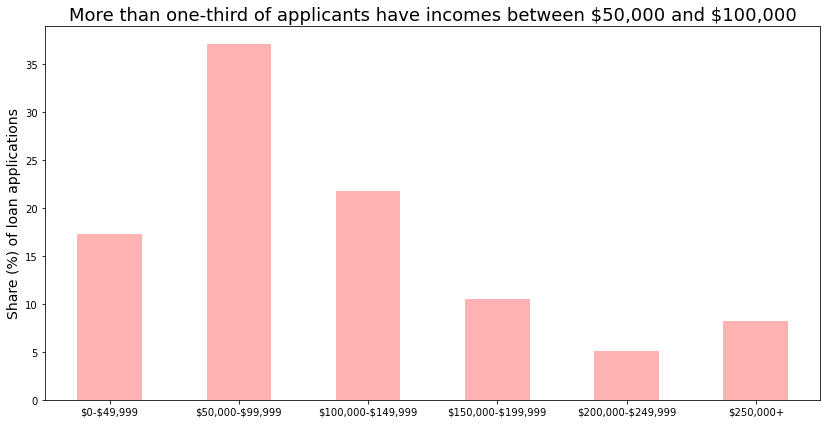

In [91]:
# income buckets

incdf=df2.groupby('incgroups')[['incgroups']].agg('count')/(df2.incgroups.count())*100
incdf=incdf.rename(columns={'incgroups':'incgroups2'})
incdf['myindex']=([1,3,4,5,6,2])
incdf=incdf.sort_values(by=['myindex'])


plt.figure(figsize = (12,6))
incdf['incgroups2'].plot.bar(color='red', alpha=0.3)
plt.xlabel('', fontsize=14)
plt.ylabel('Share (%) of loan applications', fontsize=14)
plt.xticks(rotation=0, horizontalalignment="center")

plt.title('More than one-third of applicants have incomes between \$50,000 and \$100,000', fontsize=18)

plt.tight_layout()
plt.savefig("graph2d.jpg", dpi=250)

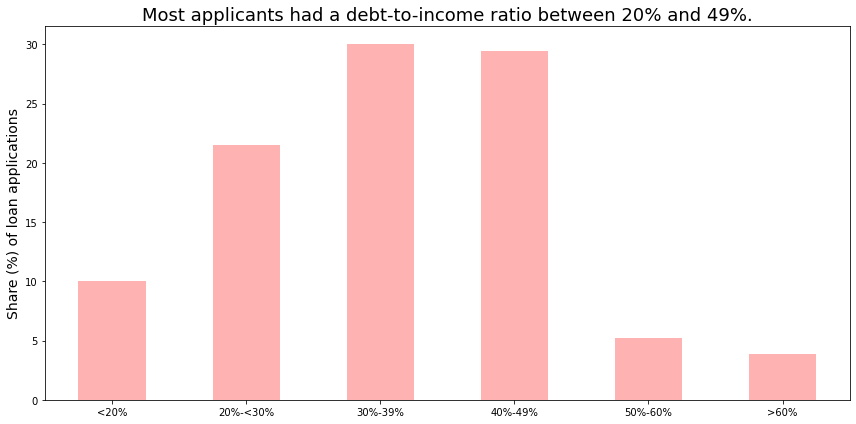

In [92]:
# debt to income ratio buckets


dtdf=df2.groupby('debt_to_income_ratio')[['debt_to_income_ratio']].agg('count')/(df2.debt_to_income_ratio.count())*100
dtdf=dtdf.rename(columns={'debt_to_income_ratio':'dtgroup'})

dtdf['myindex']=([2,3,4,5,1,6])
dtdf=dtdf.sort_values(by=['myindex'])


plt.figure(figsize = (12,6))
dtdf['dtgroup'].plot.bar(color='red', alpha=0.3)
plt.xlabel('', fontsize=14)
plt.ylabel('Share (%) of loan applications', fontsize=14)
plt.xticks(rotation=0, horizontalalignment="center")

plt.title('Most applicants had a debt-to-income ratio between 20% and 49%.', fontsize=18)

plt.tight_layout()
plt.savefig("graph2e.jpg", dpi=250)

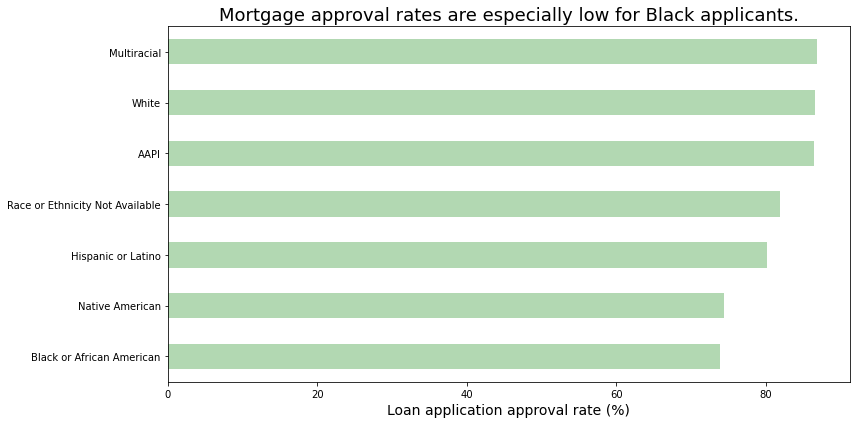

In [93]:
# race and approval rates
app1df=df2.groupby('newrace')[['outcome']].agg('mean')*100
plt.figure(figsize = (12,6))
app1df.outcome.sort_values(ascending=True).plot.barh(color='green', alpha=0.3)
plt.xlabel('Loan application approval rate (%)', fontsize=14)
plt.ylabel('', fontsize=14)
plt.title('Mortgage approval rates are especially low for Black applicants.', fontsize=18)

plt.tight_layout()
plt.savefig("graph3a.jpg", dpi=250)



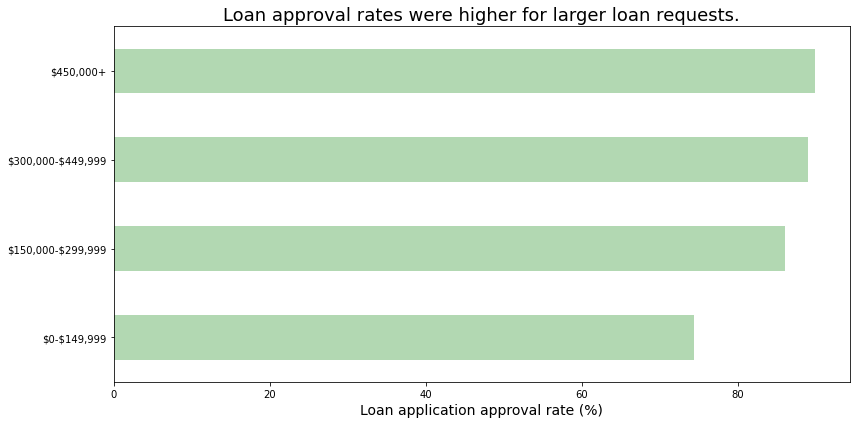

In [94]:
# loan request amount and approval rates
app2df=df2.groupby('loanbuckets')[['outcome']].agg('mean')*100
plt.figure(figsize = (12,6))
app2df.outcome.sort_values(ascending=True).plot.barh(color='green', alpha=0.3)
plt.xlabel('Loan application approval rate (%)', fontsize=14)
plt.ylabel('', fontsize=14)
plt.title('Loan approval rates were higher for larger loan requests.', fontsize=18)

plt.tight_layout()
plt.savefig("graph3b.jpg", dpi=250)


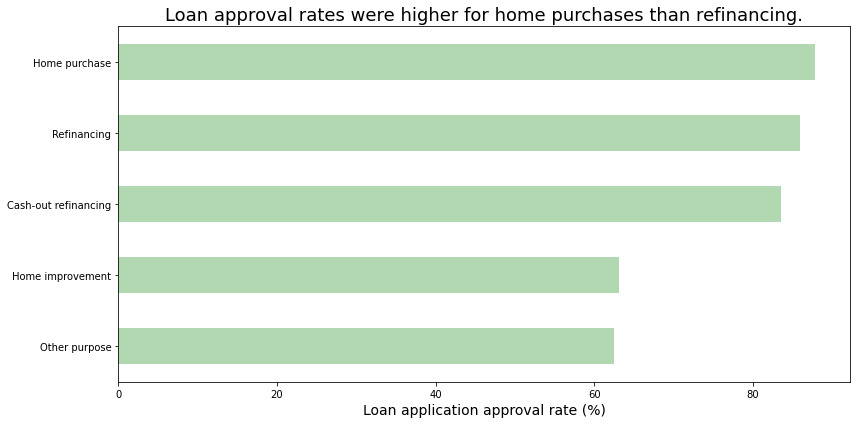

In [95]:

# loan purpose and approval rates
app3df=df2.groupby('loan_purpose')[['outcome']].agg('mean')*100
plt.figure(figsize = (12,6))
app3df.outcome.sort_values(ascending=True).plot.barh(color='green', alpha=0.3)
plt.xlabel('Loan application approval rate (%)', fontsize=14)
plt.ylabel('', fontsize=14)
plt.title('Loan approval rates were higher for home purchases than refinancing.', fontsize=18)

plt.tight_layout()
plt.savefig("graph3c.jpg", dpi=250)

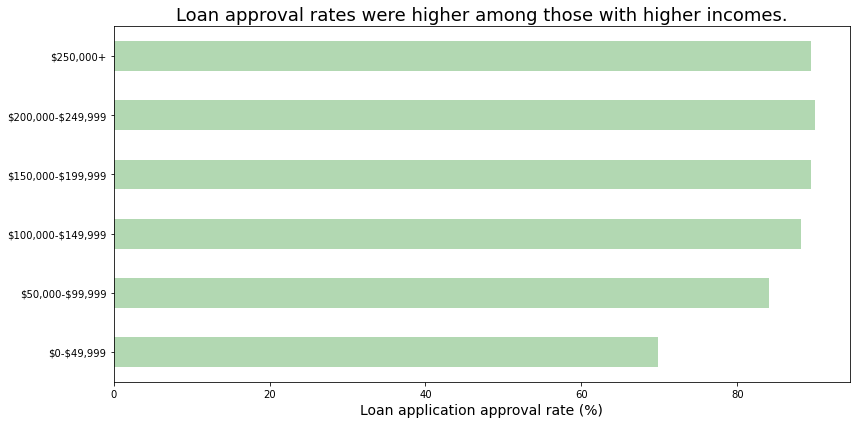

In [96]:
# income

app4df=df2.groupby('incgroups')[['outcome']].agg('mean')*100
app4df['myindex']=([1,3,4,5,6,2])
app4df=app4df.sort_values(by=['myindex'])


plt.figure(figsize = (12,6))
app4df.outcome.plot.barh(color='green', alpha=0.3)
plt.xlabel('Loan application approval rate (%)', fontsize=14)
plt.ylabel('', fontsize=14)
plt.title('Loan approval rates were higher among those with higher incomes.', fontsize=18)

plt.tight_layout()
plt.savefig("graph3d.jpg", dpi=250)

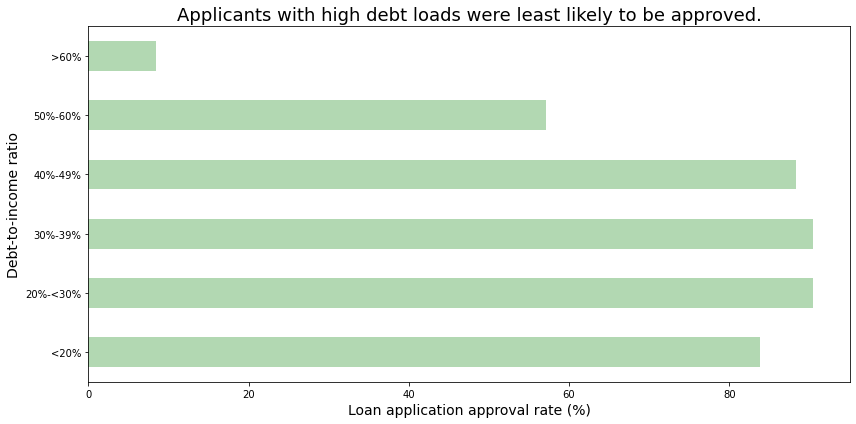

In [98]:
# debt to income ratio and approval rates
app5df=df2.groupby('debt_to_income_ratio')[['outcome']].agg('mean')*100
app5df['myindex']=([2,3,4,5,1,6])
app5df=app5df.sort_values(by=['myindex'])
plt.figure(figsize = (12,6))
app5df.outcome.plot.barh(color='green', alpha=0.3)
plt.xlabel('Loan application approval rate (%)', fontsize=14)
plt.ylabel('Debt-to-income ratio', fontsize=14)
plt.title('Applicants with high debt loads were least likely to be approved.', fontsize=18)

plt.tight_layout()
plt.savefig("graph3e.jpg", dpi=250)

In [103]:
df2.outcome.value_counts()/df2.outcome.count()*100

df2.groupby('derived_sex').outcome.mean()

derived_sex
Female               0.811474
Joint                0.879197
Male                 0.824162
Sex Not Available    0.811544
Name: outcome, dtype: float64

In [44]:
# remove outliers from loan amount and income

#noouts = df2[['income', 'loan_amount', 'outcome']]
#noouts = noouts.loc[noouts.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
#noouts.income.describe()



In [64]:
#race
#df2.groupby('newrace')['outcome'].agg('mean')
#income
#df2.groupby('incgroups')['outcome'].agg('mean')
#debt to income
#df2.groupby('debt_to_income_ratio')['outcome'].agg('mean')
# combined value to loan ratio

# property value

In [63]:

#plt.figure(figsize = (12,6))
#df2.groupby(['incgroups','newrace'])[['outcome']].agg('mean')

